Se ha seguido el tutorial para predicción de series temporales con TensorFlow: https://www.tensorflow.org/tutorials/structured_data/time_series?hl=es-419

A continuación, se presenta el código con el cuál se han construído algunos estilos diferentes de modelos basándose en redes neuronales artificiales recurrentes (RNN), en concreto Long short-term memory (LSTM).

Esto se cubre en dos partes principales, con subsecciones:

Pronóstico para un solo paso de tiempo:
- Una única salida (la variable magnitud).

Pronóstico para varios pasos de tiempo:
- Disparo único: Con todas las predicciones a la vez.
- Autorregresivo: Con una predicción a la vez y enviar la salida al modelo.

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
import math
from scipy import stats
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [ ]:
#Lectura de datos
dfi = pd.read_csv("Movimientos_sismicos.csv")
print(dfi)

             X        Y  OBJECTID_1  OBJECTID  Id  Date_  Time_  \
0     -17.8807  28.5661       70306       NaN NaN    NaN    NaN   
1     -17.8508  28.5584       70307       NaN NaN    NaN    NaN   
2     -17.8735  28.5719       70308       NaN NaN    NaN    NaN   
3     -17.8802  28.5656       70309       NaN NaN    NaN    NaN   
4     -17.8549  28.5499       70310       NaN NaN    NaN    NaN   
...        ...      ...         ...       ...  ..    ...    ...   
15557 -17.8804  28.6190       85865       NaN NaN    NaN    NaN   
15558 -17.8451  28.5525       85866       NaN NaN    NaN    NaN   
15559 -17.9003  28.6054       85867       NaN NaN    NaN    NaN   
15560 -17.8845  28.6263       85868       NaN NaN    NaN    NaN   
15561 -17.8634  28.5679       85869       NaN NaN    NaN    NaN   

                        DateTime_  ErrTime   RMS  ...    Qual  Author  \
0      2017/10/07 10:27:29.820+00     2.18  0.19  ...  m i ke     IGN   
1      2017/10/07 13:03:25.460+00     2.19  0.20 

In [ ]:
#Lectura de datos
df = pd.read_csv("Datos_Resultantes.csv")
print(df)

       Latitude  Longitude  Smin    Az  Depth  ErrDepth  Nsta    Gap  \
0       28.5661   -17.8807  10.4  81.0   21.6      12.7   5.0  189.0   
1       28.5584   -17.8508  13.6  67.0   28.2      13.0   4.0  149.0   
2       28.5719   -17.8735  10.1  87.0   24.2      14.0   5.0  181.0   
3       28.5656   -17.8802  12.1  87.0   24.4      13.7   5.0  189.0   
4       28.5499   -17.8549  10.8  90.0   26.3      11.5   5.0  168.0   
...         ...        ...   ...   ...    ...       ...   ...    ...   
15557   28.6190   -17.8804   2.4  84.0    2.5       3.6   9.0  137.0   
15558   28.5525   -17.8451   7.3  80.0   13.6       7.4  10.0  113.0   
15559   28.6054   -17.9003   2.9  75.0    3.1       3.6   9.0  193.0   
15560   28.6263   -17.8845   2.3  70.0    1.1       7.0   7.0  149.0   
15561   28.5679   -17.8634   9.1  75.0   16.5      10.2   9.0  146.0   

       Magnitud  pca_retemp  
0           1.6   -0.125555  
1           2.7   -0.193603  
2           1.7   -0.139373  
3           1.7

In [ ]:
# Extraer la columna 'DateTime_' del primer DataFrame
c = dfi['DateTime_']

# Insertar la columna en la posición 0 del segundo DataFrame
df.insert(0, 'DateTime_', c)

print(df)

                        DateTime_  Latitude  Longitude  Smin    Az  Depth  \
0      2017/10/07 10:27:29.820+00   28.5661   -17.8807  10.4  81.0   21.6   
1      2017/10/07 13:03:25.460+00   28.5584   -17.8508  13.6  67.0   28.2   
2      2017/10/07 20:09:58.790+00   28.5719   -17.8735  10.1  87.0   24.2   
3          2017/10/07 23:06:00+00   28.5656   -17.8802  12.1  87.0   24.4   
4      2017/10/08 01:23:02.150+00   28.5499   -17.8549  10.8  90.0   26.3   
...                           ...       ...        ...   ...   ...    ...   
15557  2022/02/10 02:48:10.490+00   28.6190   -17.8804   2.4  84.0    2.5   
15558  2022/02/10 04:26:19.090+00   28.5525   -17.8451   7.3  80.0   13.6   
15559  2022/02/10 04:29:03.150+00   28.6054   -17.9003   2.9  75.0    3.1   
15560  2022/02/10 05:12:46.630+00   28.6263   -17.8845   2.3  70.0    1.1   
15561      2022/02/10 06:05:20+00   28.5679   -17.8634   9.1  75.0   16.5   

       ErrDepth  Nsta    Gap  Magnitud  pca_retemp  
0          12.7   5.0 

In [ ]:
#Tipo de datos
print(df.dtypes)

DateTime_      object
Latitude      float64
Longitude     float64
Smin          float64
Az            float64
Depth         float64
ErrDepth      float64
Nsta          float64
Gap           float64
Magnitud      float64
pca_retemp    float64
dtype: object


In [ ]:
#Transformación variable DateTime_ de categórica a fecha y hora y en formato aaaa/mm/dd H:M:S
def convertir_fecha(DateTime_):
    try:
        return pd.to_datetime(DateTime_, format='%Y/%m/%d %H:%M:%S.%f%z').strftime('%Y/%m/%d %H:%M:%S')
    except ValueError:
        pass
    try:
        # Intentar convertir la fecha con el formato '%Y/%m/%d %H:%M:%S.%f %z'
        return pd.to_datetime(DateTime_, format='%Y/%m/%d %H:%M:%S%z').strftime('%Y/%m/%d %H:%M:%S')
    except ValueError:
        pass
    # Si no se puede convertir, devolver None
    return None

# Aplicar la función convertir_fecha a la columna de fecha
df['DateTime_'] = df['DateTime_'].apply(convertir_fecha)

In [ ]:
"""
#Frecuencia de muestreo
sample_freq = 60
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)

df = df[0::steps]
"""

'\n#Frecuencia de muestreo\nsample_freq = 60\nsteps=int(sample_freq/5)\ntime_steps = int(60/sample_freq)\n\ndf = df[0::steps]\n'

In [ ]:
#Mostramos los datos
df.head()

,DateTime_,Latitude,Longitude,Smin,Az,Depth,ErrDepth,Nsta,Gap,Magnitud,pca_retemp
0,2017/10/07 10:27:29,28.5661,-17.8807,10.4,81.0,21.6,12.7,5.0,189.0,1.6,-0.125555
1,2017/10/07 13:03:25,28.5584,-17.8508,13.6,67.0,28.2,13.0,4.0,149.0,2.7,-0.193603
2,2017/10/07 20:09:58,28.5719,-17.8735,10.1,87.0,24.2,14.0,5.0,181.0,1.7,-0.139373
3,2017/10/07 23:06:00,28.5656,-17.8802,12.1,87.0,24.4,13.7,5.0,189.0,1.7,-0.135564
4,2017/10/08 01:23:02,28.5499,-17.8549,10.8,90.0,26.3,11.5,5.0,168.0,2.6,-0.127914


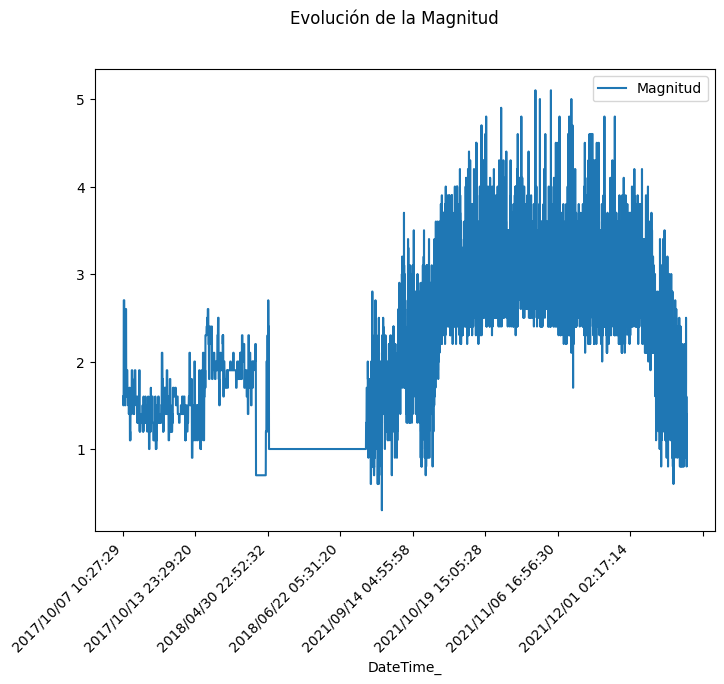

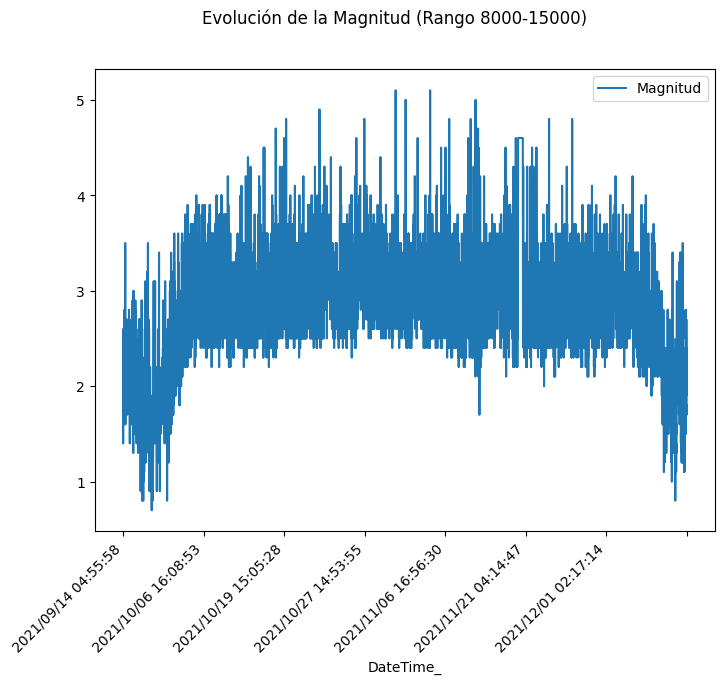

In [ ]:
df = df.set_index('DateTime_').sort_index()

plot_cols = ['Magnitud']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True, title='Evolución de la Magnitud')
plt.xticks(rotation=45, ha='right')


plot_features = df[plot_cols][8000:15000]
_ = plot_features.plot(subplots=True, title='Evolución de la Magnitud (Rango 8000-15000)')
plt.xticks(rotation=45, ha='right')


plt.show()

In [ ]:
"""
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('DateTime_'), format='%d.%m.%Y %H:%M:%S')
"""

"\ndf = pd.read_csv(csv_path)\n# Slice [start:stop:step], starting from index 5 take every 6th record.\ndf = df[5::6]\n\ndate_time = pd.to_datetime(df.pop('DateTime_'), format='%d.%m.%Y %H:%M:%S')\n"

In [ ]:
#Estadística descriptiva del conjunto de datos
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Latitude,15562.0,2.859777e+01,0.072274,28.186000,28.558825,28.568300,28.609100,29.219800
Longitude,15562.0,-1.783759e+01,0.042316,-18.115400,-17.857800,-17.835700,-17.819100,-17.287200
Smin,15562.0,6.463739e+00,3.689651,1.400000,3.700000,5.000000,9.100000,30.900000
Az,15562.0,9.251799e+01,33.767785,0.000000,74.000000,82.000000,95.000000,178.000000
Depth,15562.0,1.391158e+01,9.682166,0.000000,7.800000,11.500000,21.500000,91.500000
ErrDepth,15562.0,7.978332e+00,4.453136,1.600000,5.100000,6.400000,10.800000,90.800000
Nsta,15562.0,1.026745e+01,6.411228,3.000000,6.000000,8.000000,13.000000,58.000000
Gap,15562.0,1.493190e+02,60.268006,49.000000,108.000000,127.000000,183.000000,348.000000
Magnitud,15562.0,2.043471e+00,0.849507,0.300000,1.300000,1.900000,2.700000,5.100000
pca_retemp,15562.0,5.113789e-17,0.516641,-0.481575,-0.212193,-0.141267,-0.070805,3.828934


In [ ]:
df = df.reset_index()

# Convertir la columna 'DateTime_' a tipo datetime
df['DateTime_'] = pd.to_datetime(df['DateTime_'])

#Convertimos la columna date_time en cadena
date_time = df['DateTime_']

# Convertir a timestamp (segundos desde la época)
timestamp_s = date_time.map(lambda x: x.timestamp())

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

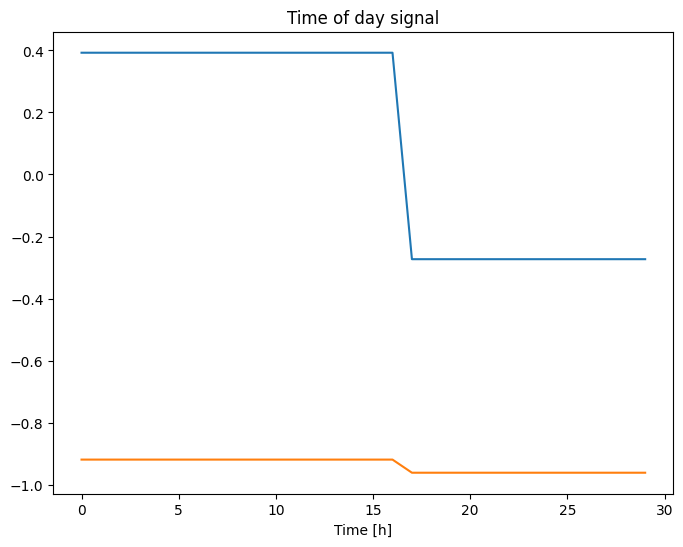

In [ ]:
plt.plot(np.array(df['Day sin'])[:30])
plt.plot(np.array(df['Day cos'])[:30])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

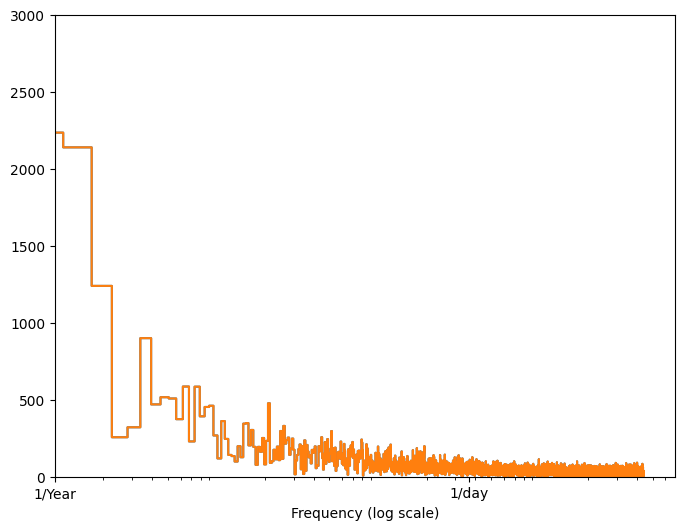

In [ ]:
fft = tf.signal.rfft(df['Magnitud'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Magnitud'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 3000)
fft = tf.signal.rfft(df['Magnitud'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Magnitud'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 3000)
plt.xlim([1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
#Se divide el conjunto de datos en entrenamiento, validación y prueba (70%, 20% y 10%, respectivamente)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
#Normalización de variables
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<ipython-input-168-3f5d65d274a0>:5: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train_df = (train_df - train_mean) / train_std
<ipython-input-168-3f5d65d274a0>:6: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val_df = (val_df - train_mean) / train_std
<ipython-input-168-3f5d65d274a0>:7: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test_df = (test_df - train_mean) / train_std


<ipython-input-169-4ec9be458a7e>:1: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_std = (df - train_mean) / train_std
<ipython-input-169-4ec9be458a7e>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


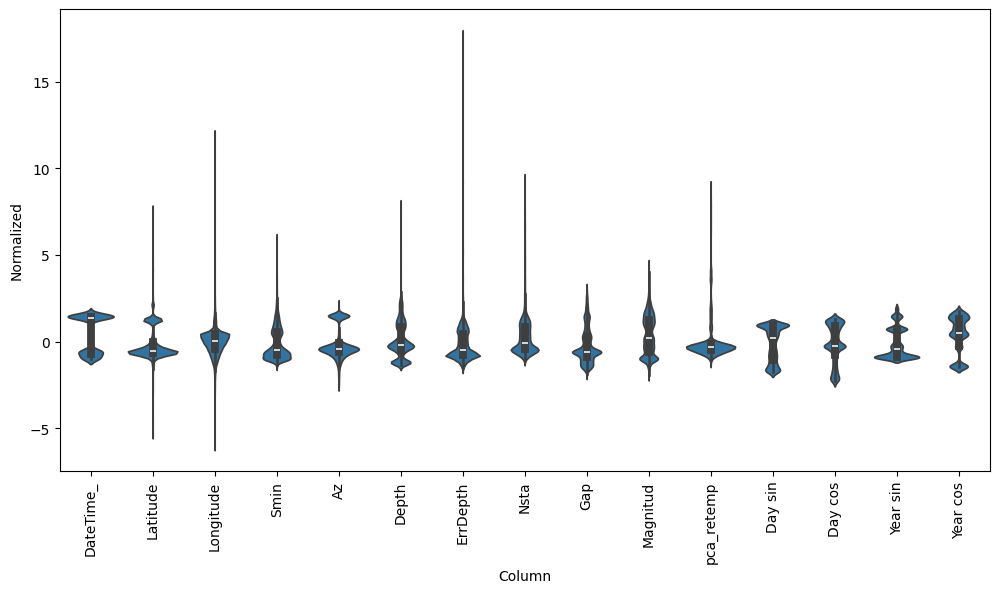

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

#Ventana de datos

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Creación de ventanas:

24 hours prior --> predict 1 hour
24 hours prior --> predict 6 hours
48 hours prior --> predict 1 hours
48 hours prior --> predict 6 hours
48 hours prior --> predict 12 hours
48 hours prior --> predict 24 hours

In [ ]:
w1 = WindowGenerator(input_width=12, label_width=12, shift=1,
                     label_columns=['Magnitud'])
w1

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['Magnitud']

In [ ]:
w2 = WindowGenerator(input_width=12, label_width=12, shift=6,
                     label_columns=['Magnitud'])
w2

Total window size: 18
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17]
Label column name(s): ['Magnitud']

In [ ]:
w3 = WindowGenerator(input_width=24, label_width=24, shift=1,
                     label_columns=['Magnitud'])
w3

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Magnitud']

In [ ]:
w4 = WindowGenerator(input_width=24, label_width=24, shift=6,
                     label_columns=['Magnitud'])
w4

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['Magnitud']

In [ ]:
w5 = WindowGenerator(input_width=24, label_width=24, shift=12,
                     label_columns=['Magnitud'])
w5

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
Label column name(s): ['Magnitud']

In [ ]:
w6 = WindowGenerator(input_width=48, label_width=48, shift=1,
                     label_columns=['Magnitud'])
w6

Total window size: 49
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
Label column name(s): ['Magnitud']

In [ ]:
w7 = WindowGenerator(input_width=48, label_width=48, shift=6,
                     label_columns=['Magnitud'])
w7

Total window size: 54
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
Label column name(s): ['Magnitud']

In [ ]:
w8 = WindowGenerator(input_width=48, label_width=48, shift=12,
                     label_columns=['Magnitud'])
w8

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
Label column name(s): ['Magnitud']

In [ ]:
w9 = WindowGenerator(input_width=48, label_width=48, shift=24,
                     label_columns=['Magnitud'])
w9

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): ['Magnitud']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 13, 15)
Inputs shape: (3, 12, 15)
Labels shape: (3, 12, 1)


Aquí hay un método de trazado que permite una visualización simple de la ventana dividida:

In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Magnitud', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Este diagrama alinea entradas, etiquetas y predicciones ( posteriores ) en función del tiempo al que se refiere el elemento:

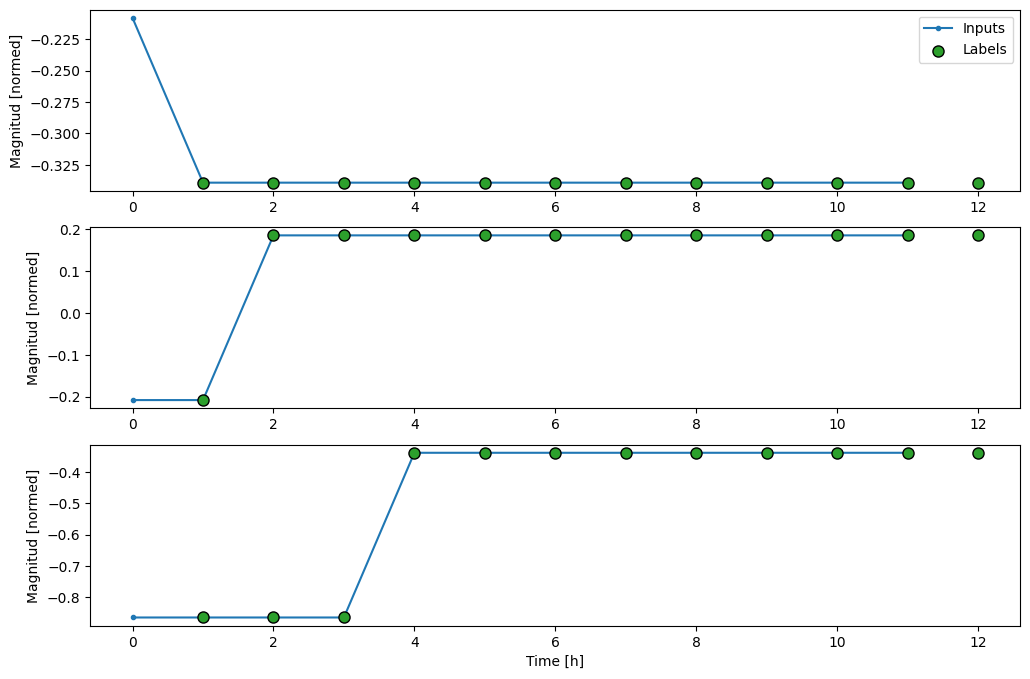

In [ ]:
w1.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 12, 15), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 12, 15)
Labels shape (batch, time, features): (32, 12, 1)


#Single-Step LSTM

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Magnitud'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Magnitud']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 15)
Labels shape (batch, time, features): (32, 1, 1)


#Base

Antes de construir un modelo entrenable, sería bueno tener una línea de base de rendimiento como punto de comparación con los modelos posteriores más complicados.

Esta primera tarea es predecir la magnitud una hora hacia el futuro, dado el valor actual de todas las características. Los valores actuales incluyen la la magnitud actual.


In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiar y evaluar este modelo:

In [ ]:
baseline = Baseline(label_index=column_indices['Magnitud'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4891 - mean_absolute_error: 0.5052


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Magnitud'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Magnitud']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 1)


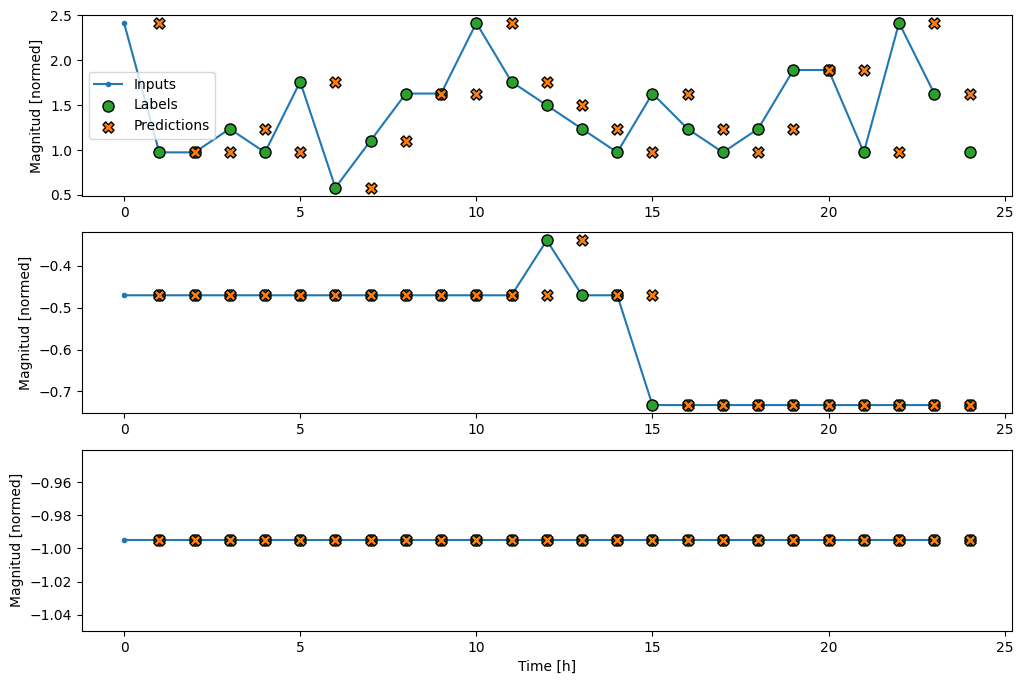

In [ ]:
wide_window.plot(baseline)

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.Accuracy()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


#RNN

Una red neuronal recurrente ( RNN ) es un tipo de red neuronal muy adecuada para los datos de series temporales. Los RNN procesan una serie temporal paso a paso, manteniendo un estado interno desde el paso del tiempo hasta el paso del tiempo.

En este tutorial, usará una capa RNN llamada Memoria larga a corto plazo (tf.keras.layers.LSTM).

Un argumento constructor importante para todas las capas Keras RNN, como tf.keras.layers.LSTM, es el return_sequences argumento. Esta configuración puede configurar la capa de una de dos maneras:

Si False, el valor predeterminado, la capa solo devuelve la salida del paso de tiempo final, dando al modelo tiempo para calentar su estado interno antes de hacer una sola predicción:

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

Si True, la capa devuelve una salida para cada entrada. Esto es útil para:
Apilamiento de capas RNN.
Entrenar un modelo en múltiples pasos de tiempo simultáneamente.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Con return_sequences=True, el modelo se puede capacitar en 24 horas de datos a la vez.

Nota: Esto dará una visión pesimista del rendimiento del modelo. En el primer paso, el modelo no tiene acceso a pasos anteriores y, por lo tanto, no puede hacerlo mejor que el simple linear y dense modelos mostrados anteriormente.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.3266 - mean_absolute_error: 0.4440 - mean_squared_error: 0.3266 - root_mean_squared_error: 0.5715


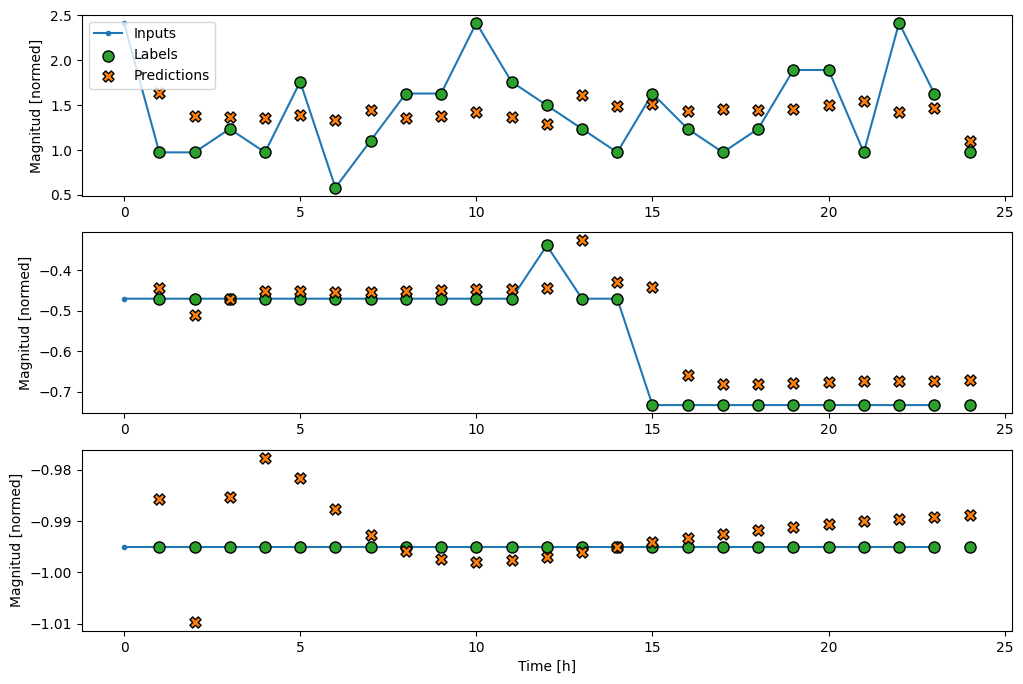

In [ ]:
wide_window.plot(lstm_model)

Con este conjunto de datos, generalmente cada uno de los modelos funciona un poco mejor que el anterior:

In [ ]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>,
 <MeanSquaredError name=mean_squared_error>,
 <RootMeanSquaredError name=root_mean_squared_error>,
 <Accuracy name=accuracy>]

In [ ]:
val_performance

{'Baseline': [0.4451577067375183, 0.4845724105834961],
 'LSTM': [0.32666340470314026,
  0.44478562474250793,
  0.32666340470314026,
  0.5715447664260864,
  0.0]}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index(metric_name)

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Magnitude, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()
plt.show()


ValueError: 'mae' is not in list

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Magnitud, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Magnitud, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

ValueError: 'MeanAbsoluteError' is not in list

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

#Conexiones residuales

los Baseline El modelo anterior aprovechó el hecho de que la secuencia no cambia drásticamente de un paso a otro. Todos los modelos entrenados en este tutorial hasta el momento se inicializaron aleatoriamente y luego tuvieron que aprender que el resultado es un pequeño cambio con respecto al paso de tiempo anterior.

Si bien puede solucionar este problema con una inicialización cuidadosa, es más simple incorporar esto en la estructura del modelo.

Es común en el análisis de series de tiempo construir modelos que, en lugar de predecir el siguiente valor, predigan cómo cambiará el valor en el próximo paso de tiempo. Del mismo modo, redes residuales— o ResNets — en el aprendizaje profundo se refieren a arquitecturas donde cada capa se suma al resultado acumulativo del modelo.

Así es como aprovechas el conocimiento de que el cambio debería ser pequeño.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Esencialmente, esto inicializa el modelo para que coincida con el Baseline. Para esta tarea, ayuda a los modelos a converger más rápido, con un rendimiento ligeramente mejor.



Aquí, se está aplicando al modelo LSTM, tenga en cuenta el uso del tf.initializers.zeros para garantizar que los cambios pronosticados iniciales sean pequeños y no dominen la conexión residual. No hay preocupaciones de ruptura de simetría para los gradientes aquí, ya que el zeros solo se usan en la última capa.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.8905e-07 - loss: 0.4200 - mean_absolute_error: 0.5093 - mean_squared_error: 0.4200 - root_mean_squared_error: 0.6480

CPU times: user 1min 31s, sys: 5.71 s, total: 1min 36s
Wall time: 1min 32s


#Multi-steps LSTM

Las actuaciones anteriores se promedian en todas las salidas del modelo.

Esta sección analiza cómo expandir estos modelos para hacer predicciones de pasos de tiempo múltiples.

En una predicción de varios pasos, el modelo necesita aprender a predecir un rango de valores futuros. Por lo tanto, a diferencia de un modelo de un solo paso, donde solo se predice un único punto futuro, un modelo de varios pasos predice una secuencia de los valores futuros.

Hay dos enfoques aproximados para esto:

Predicciones de un solo disparo donde se predice toda la serie temporal a la vez.
Predicciones autorregresivas donde el modelo solo hace predicciones de un solo paso y su salida se retroalimenta como su entrada.
En esta sección todos los modelos predecirán todas las funciones en todos los pasos de tiempo de salida.

Para el modelo de varios pasos, los datos de capacitación nuevamente consisten en muestras por hora. Sin embargo, aquí, los modelos aprenderán a predecir las 24 horas en el futuro, dadas las 24 horas del pasado.

Aquí hay un Window objeto que genera estos cortes a partir del conjunto de datos:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

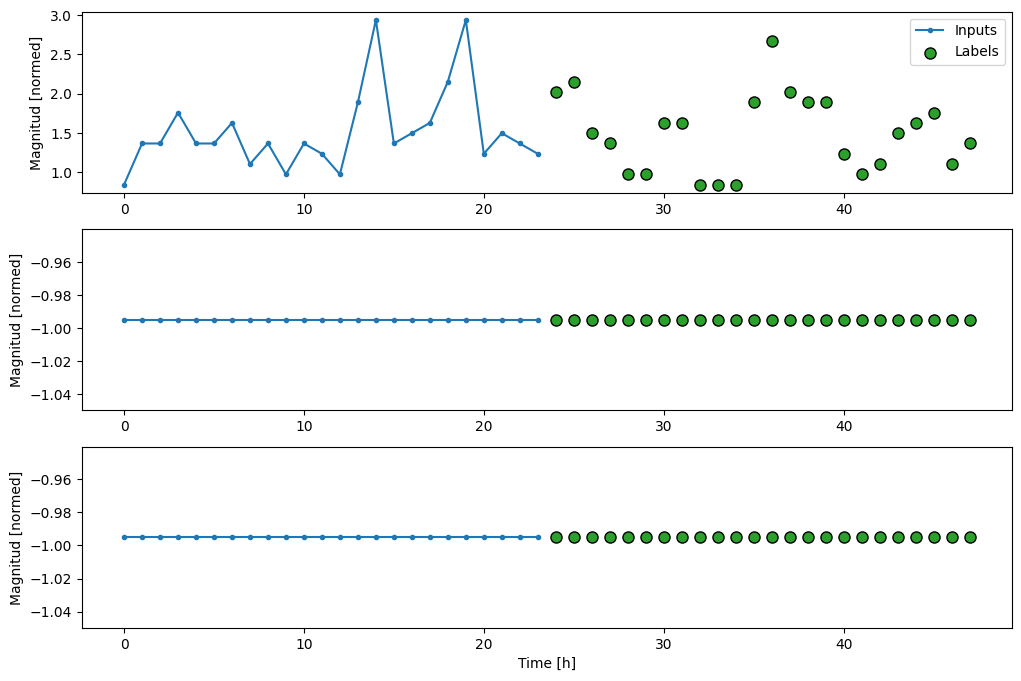

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#Baseline

Una línea de base simple para esta tarea es repetir el último paso de tiempo de entrada para el número requerido de pasos de tiempo de salida:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1499 - mean_absolute_error: 0.5315


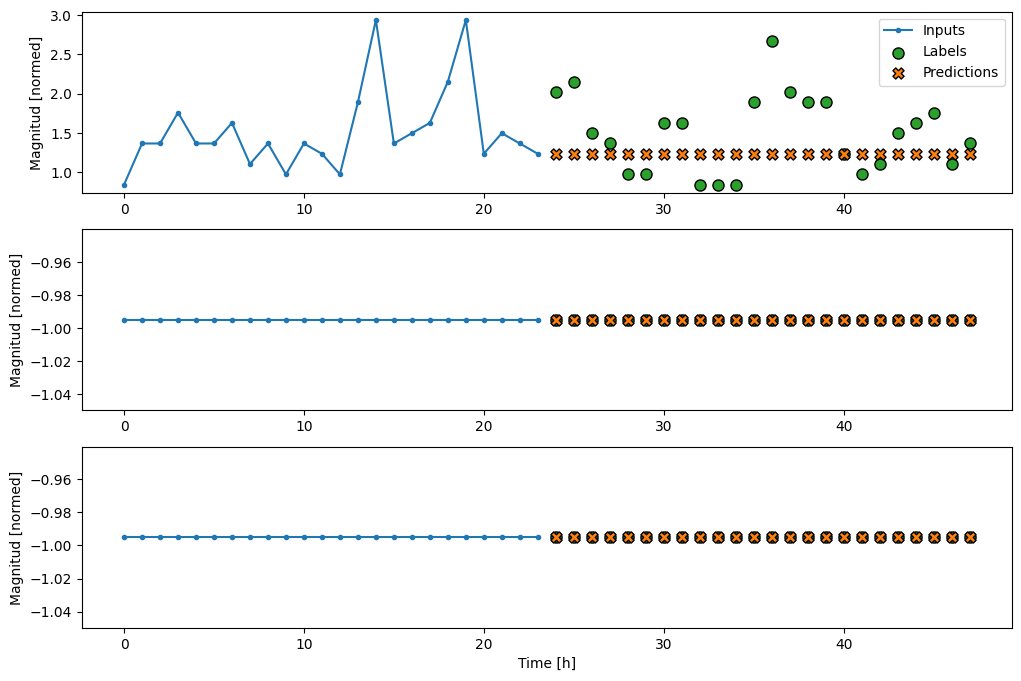

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Dado que esta tarea es predecir 24 horas en el futuro, dadas las 24 horas del pasado, otro enfoque simple es repetir el día anterior, suponiendo que mañana sea similar:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3202 - mean_absolute_error: 0.6053


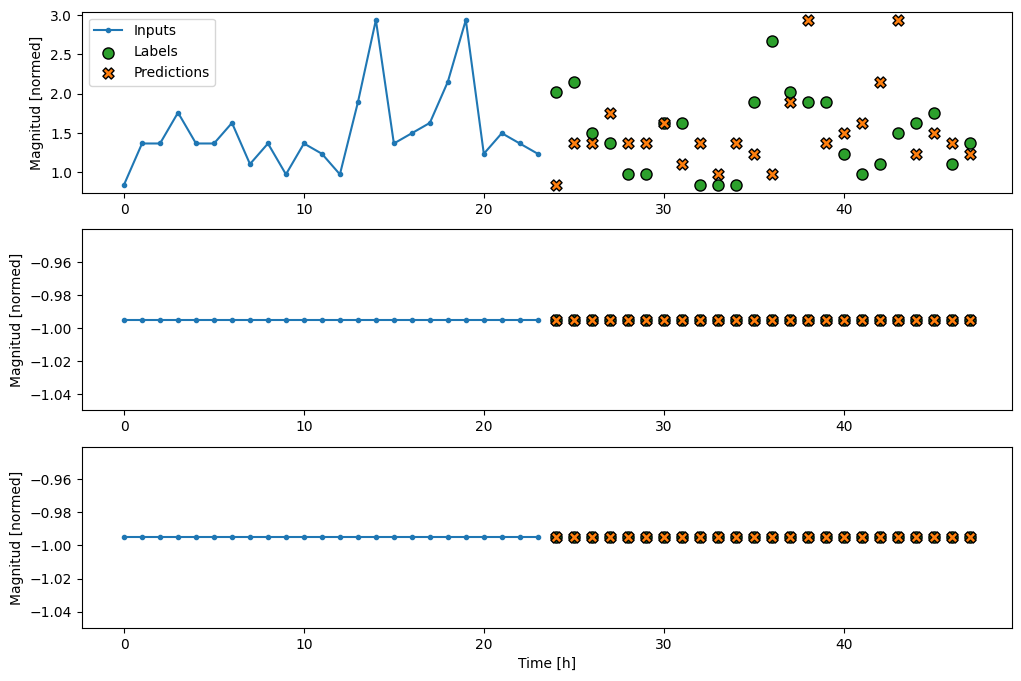

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

##Modelos de un solo disparo

Un enfoque de alto nivel para este problema es usar un modelo de "punto único", donde el modelo hace la predicción de secuencia completa en un solo paso.

Esto se puede implementar eficientemente como tf.keras.layers.Dense con OUT_STEPS*features unidades de salida. El modelo solo necesita remodelar esa salida a la requerida (OUTPUT_STEPS, features).

Lineal
Un modelo lineal simple basado en el último paso de tiempo de entrada es mejor que cualquiera de las líneas de base, pero tiene poca potencia. El modelo necesita predecir OUTPUT_STEPS pasos de tiempo, desde un solo paso de tiempo de entrada con una proyección lineal. Solo puede capturar una porción de baja dimensión del comportamiento, probablemente basado principalmente en la hora del día y la época del año.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

#RNN

Un modelo recurrente puede aprender a usar una larga historia de entradas, si es relevante para las predicciones que está haciendo el modelo. Aquí el modelo acumulará estado interno durante 24 horas, antes de hacer una sola predicción durante las próximas 24 horas.

En este formato de disparo único, el LSTM solo necesita producir una salida en el último paso de tiempo, así que configure return_sequences=False en tf.keras.layers.LSTM.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0000e+00 - loss: 0.6670 - mean_absolute_error: 0.5040 - mean_squared_error: 0.6670 - root_mean_squared_error: 0.8166


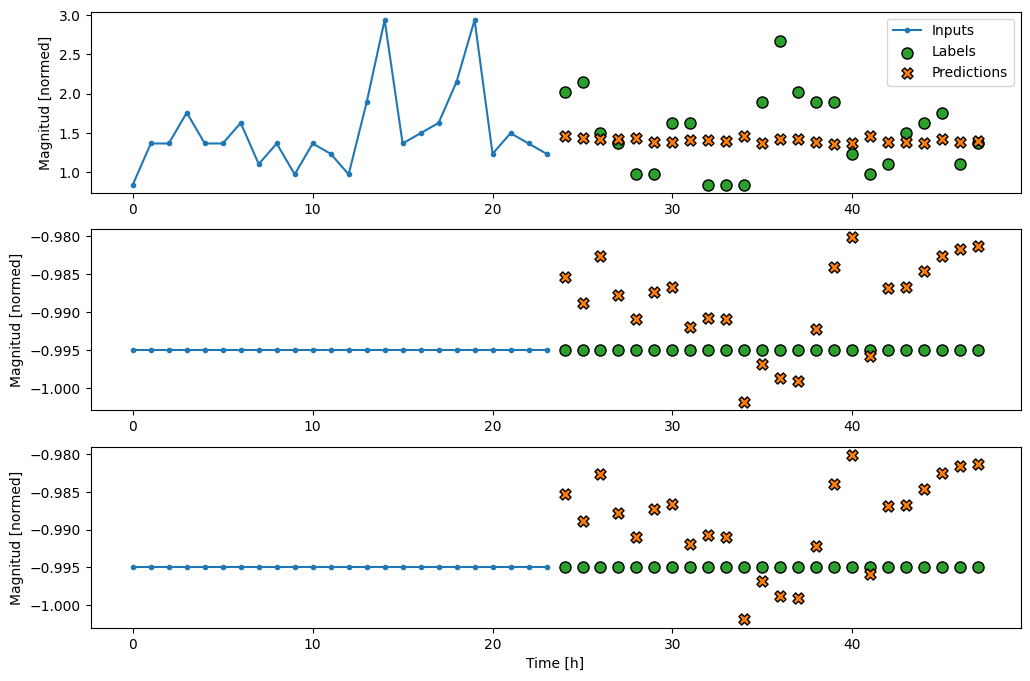

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#Modelo autorregresivo

Todos los modelos anteriores predicen la secuencia de salida completa en un solo paso.

En algunos casos, puede ser útil que el modelo descomponga esta predicción en pasos de tiempo individuales. Luego, la salida de cada modelo se puede retroalimentar en sí misma en cada paso y las predicciones se pueden condicionar en el anterior, como en el clásico Generando secuencias con redes neuronales recurrentes.

Una clara ventaja de este estilo de modelo es que se puede configurar para producir resultados con una longitud variable.

Puede tomar cualquiera de los modelos de salida múltiple de un solo paso entrenados en la primera mitad de este tutorial y ejecutarse en un ciclo de retroalimentación autorregresiva, pero aquí te concentrarás en construir un modelo que haya sido entrenado explícitamente para hacerlo.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#RNN

Este tutorial solo crea un modelo RNN autorregresivo, pero este patrón podría aplicarse a cualquier modelo diseñado para generar un solo paso de tiempo.

El modelo tendrá la misma forma básica que los modelos LSTM de un solo paso de antes: a tf.keras.layers.LSTM capa seguida de un tf.keras.layers.Dense capa que convierte el LSTM salidas de capa para modelar predicciones.

A tf.keras.layers.LSTM es un tf.keras.layers.LSTMCell envuelto en el nivel superior tf.keras.layers.RNN que gestiona los resultados de estado y secuencia para usted ( Consulte el Redes neuronales recurrentes ( RNN ) con queras guía de detalles ).

En este caso, el modelo tiene que administrar manualmente las entradas para cada paso, por lo que utiliza tf.keras.layers.LSTMCell directamente para el nivel inferior, interfaz de paso de tiempo único.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

El primer método que necesita este modelo es un warmup método para inicializar su estado interno basado en las entradas. Una vez entrenado, este estado capturará las partes relevantes del historial de entrada. Esto es equivalente al paso único LSTM modelo de antes:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Este método devuelve una única predicción de paso de tiempo y el estado interno de la LSTM:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

Con el RNN's estado, y una predicción inicial ahora puede continuar iterando el modelo alimentando las predicciones en cada paso hacia atrás como entrada.

El enfoque más simple para recopilar las predicciones de salida es usar una lista de Python y un tf.stack después del bucle.

Nota: Apilar una lista de Python como esta solo funciona con ejecución ansiosa, usando Model.compile(..., run_eagerly=True) para entrenamiento, o con una salida de longitud fija. Para una longitud de salida dinámica, necesitaría usar un tf.TensorArray en lugar de una lista de Python, y tf.range en lugar de la Python range.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Pruebe ejecutar este modelo en las entradas de ejemplo:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Ahora entrena el modelo:

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

#Actuación

Hay rendimientos claramente decrecientes en función de la complejidad del modelo en este problema

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')